# Variational Autoencoders

## Probability Theory
### Relationship between standard deviation and variance

Variance ($v$) is the measure of a set of values. It quantifies how much the values in a dataset differ from the mean of the dataset. Mathematically, for a random variable 
$X$, the variance is defined as:
$$ v = \sigma^2 = \mathbb{E}[(X - \mu)] $$

where $\mu$ is the mean of $X$, and $\mathbb{E}$ denotes expected value.
Standard Deviation ($\sigma$) is a measure of the amount of variation or dispersion in a set of values. It is the square root of the variance $v$, providing a measure of spread in the same units as the data. Mathematically, the standard deviation is:
$$ \sigma = \sqrt{v} $$

If we perform some operation of $\log$ and $e$, we can retrieve the relationship of $\log(v)$ and $\sigma$ as:
$$
\sigma = \sqrt{v} \\
\ln{\sigma} = \ln(\sqrt{v}) \\
\ln{\sigma} = \frac{1}{2} \ln{v} \\
e^{\ln{\sigma}} = e^{\frac{1}{2} \ln{v}} \\
\sigma = e^{\frac{1}{2} \ln{v}}
\sigma = \sqrt{e^{\ln(v)}}
$$

### Gaussian distribution
Math formula:
$$
P(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{\frac{-1}{2}(\frac{x - \mu}{\sigma})^2}
$$

### Variational autoender theory
#### Overview
The VAE consists of three main components/blocks:
1. Encoder: Map input data $X$ into latent representation $Z$. This is typically represented as a Gaussian distribution parameterized by mean $\mu$ and standard deviation $\sigma$.
2. Decoder: Reconstructs the input data from the latent representation $Z \rightarrow$ produce $X' \sim X$.

The VAE aims to maximize the Evidence Lower Bound (ELBO) which consists of two terms:
1. Reconstruction Loss: Measures how well the decoder can reconstruct the input data from the latent representation.
2. KL Divergence: Measures how close the learned latent distribution is to the prior distribution (usually a standard normal distribution).
#### Reparameterization trick
Without the reparameterization trick, backpropagation through the stochastic layer (sampling from the latent distribution) would be intractable because the sampling process introduces non-differentiability. The reparameterization trick addresses this issue by expressing the random variable $Z$ as a deterministic function of the model parameters and some additional noise. 

Instead of sampling $Z$ from $\mathcal{N}(\mu, \sigma^2)$, we reparameterize $Z$ as $Z = \mu + \epsilon \cdot \sigma$ where $\epsilon$ is sampled from standard normal distribution $\epsilon \sim \mathcal{N}(0, 1)$. This transformation allows us to rewrite the sampling process in a way that the gradients can flow through $\mu$ and $\sigma$ during backpropagation, since $\epsilon$ is a fixed random variable. 

#### The Kullback-Leibler (KL) Divergence Loss
Divergence loss, specifically the Kullback-Leibler (KL) divergence loss, is a crucial component in the training of Variational Autoencoders (VAEs). It measures how one probability distribution diverges from a second, reference probability distribution. In the context of VAEs, the KL divergence loss ensures that the learned latent space distribution is close to a prior distribution, typically a standard normal distribution.

KL divergence, $D_KL(P \| Q)$, between two probability distributions $P$ and $Q$ is defined as:
$$ D_{KL}(P \| Q) = \int P(x) \log(\frac{P(x)}{Q(x)})dx$$

In discreate form, it is:
$$ D_{KL}(P \| Q) = \sum_x P(x) \log \frac{P(x)}{Q(x)}$$

Intepretation:
- Asymmetry: KL divergence is not symmetric, meaning $_{KL}(P \| Q) \neq _{KL}(Q \| P)$
- Non-negativity: $_{KL}(P \| Q) \geq 0$, with equality if and only if $P = Q$
- Information Gain: KL divergence measures the amount of information lost when $Q$ is used to approximate $P$

**KL Divergence Calculation in VAEs**

Let $q(z|x)$ be the encoder's output distribution (typically Gaussian with mean $\mu$ and standard deviation $\sigma$) and $p(z)$ be the prior (standard normal distribution). The KL divergence for each data point $x$ is:

$$ D_{KL}(q(z|x) \parallel p(z)) = \int q(z|x) \log \frac{q(z|x)}{p(z)} \, dz $$

This KL Divergence loss between two Gaussian distributions $\mathcal{N}(\mu_1, \sigma_1^2)$ and $\mathcal{N}(\mu_2, \sigma_2^2)$ is given by:

$$ D_{KL} ( \mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)) = \frac{1}{2} \left( \log \frac{\sigma_2^2}{\sigma_1^2} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{\sigma_2^2} - 1 \right) $$

or we can replace $\sigma^2 = v$ into the formula:

$$ D_{KL} ( \mathcal{N}(\mu_1, v_1) \| \mathcal{N}(\mu_2, v_2)) = \frac{1}{2} \left( \log \frac{v_2}{v_1} + \frac{v_1 + (\mu_1 - \mu_2)^2}{v_2} - 1 \right) $$

For a Gaussian $q(z|x) = \mathcal{N}(z; \mu, \sigma^2)$ and $p(z) = \mathcal{N}(0, 1)$, this can be computed in the similar fashion:

$$
D_{KL}(\mathcal{N}(\mu, \sigma^2) \parallel \mathcal{N}(0, 1)) = \frac{1}{2} \left( \log \frac{1}{\sigma^2} + \frac{\sigma^2 + \mu^2}{1} - 1 \right)
$$

If we take the input of $\log(v)$ and $\mu$, by simply using simple operation, the function can be formulated as:

$$
D_{KL}(\mu, \log(v)) = \frac{1}{2} ( 1 + \log(v) - \mu^2 - e^{\log(v)})
$$

This formula quantifies how much the distribution $ \mathcal{N}(\mu, \sigma^2) $ diverges from the standard normal distribution $ \mathcal{N}(0, 1) $. In the context of VAEs, minimizing this KL divergence ensures that the learned latent space distribution closely matches the desired prior distribution (standard normal), thereby facilitating efficient and effective generation of new data points from the latent space.

## MNIST Dataset

In [1]:
%cd "../"

/workspace/DeepVisualization


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
import numpy as np
from tqdm import tqdm
import umap
from torchvision.utils import make_grid

### Prepare dataset

In [3]:
def get_dataloaders_mnist(batch_size, num_workers=0, validation_fraction=None, train_transforms=None, test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=train_transforms,
                                   download=True)

    valid_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=test_transforms)

    test_dataset = datasets.MNIST(root='data',
                                  train=False,
                                  transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 60000)
        train_indices = torch.arange(0, 60000 - num)
        valid_indices = torch.arange(60000 - num, 60000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)
    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader


In [4]:
train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=256, 
    num_workers=2, 
    validation_fraction=0.
)

In [5]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([4, 0, 0, 8, 8, 8, 4, 3, 0, 1])

Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


### Implement architecture

In [6]:
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]
    
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.relu1 = nn.LeakyReLU(0.01)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=2, kernel_size=3, padding=1)
        self.relu2 = nn.LeakyReLU(0.01)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, stride=2, kernel_size=3, padding=1)
        self.relu3 = nn.LeakyReLU(0.01)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.z_mean = torch.nn.Linear(3136, 200)
        self.z_log_var = torch.nn.Linear(3136, 200)
        
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        x = self.flatten(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Linear(in_features=200, out_features=3136)
        self.trans_conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.relu1 = nn.LeakyReLU(0.01)
        self.trans_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, stride=2, kernel_size=3, padding=1)
        self.relu2 = nn.LeakyReLU(0.01)
        self.trans_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=3, padding=0)                
        self.relu3 = nn.LeakyReLU(0.01)
        self.trans_conv4 = nn.ConvTranspose2d(in_channels=32, out_channels=1, stride=1, kernel_size=3, padding=0)        
        self.trim = Trim()

        
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 64, 7, 7)
        x = self.relu1(self.trans_conv1(x))
        x = self.relu2(self.trans_conv2(x))
        x = self.relu3(self.trans_conv3(x))
        x = self.trans_conv4(x)
        x = self.trim(x)
        return x
    
class Reparameterization(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).cuda()
        z = z_mu + eps * torch.exp(0.5 * z_log_var)
        return z

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.reparam = Reparameterization()
        self.decoder = Decoder()

    def encoding_fn(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.reparam(z_mean, z_log_var)
        return z
        
    def forward(self, x):
        z_mu, z_log_var = self.encoder(x)
        z = self.reparam(z_mu, z_log_var)
        x_ = self.decoder(z)
        return z, z_mu, z_log_var, x_

In [85]:
x = torch.randn(1, 1, 28, 28).cuda()
model = VAE().cuda()
z, z_mu, z_log_var, x_ = model(x)

Viualize Gaussian distribution

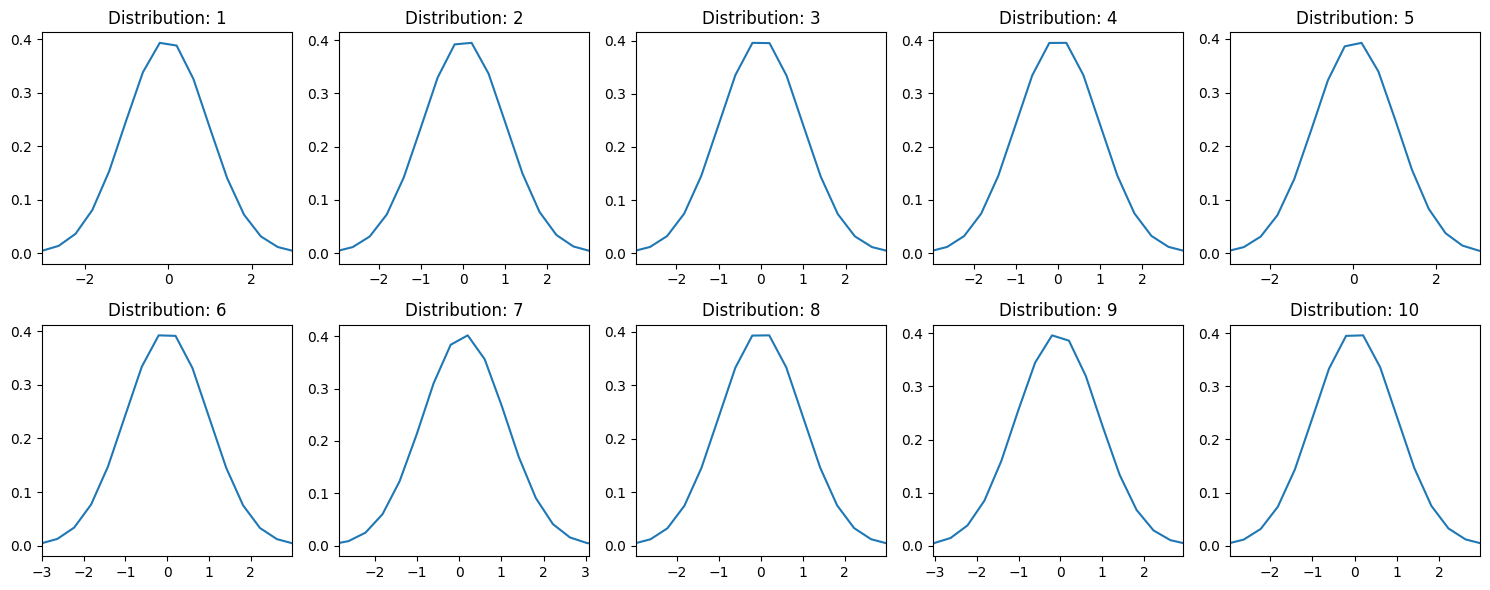

In [116]:
# Compute mu (mean) and sigma (standard deviation)
for x, _ in train_loader:
    x = x[0].unsqueeze(0).cuda()
    z, z_mu, z_log_var, x_ = model(x)
    break

z_sigma = torch.sqrt(torch.exp(z_log_var))
z_sigma = z_sigma.detach().cpu().numpy()
z_mu = z_mu.detach().cpu().numpy()

# Visualization of Gaussian distribution
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

x = np.linspace(-20, 20, 100)

def p(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

for i in range(10):
    y = p(x=x, mu=z_mu[0, i], sigma=z_sigma[0, i])
    axs[i].plot(x, y)
    axs[i].set_title(f"Distribution: {i+1}")
    axs[i].set_xlim([z_mu[0, i] - 3 * z_sigma[0, i], z_mu[0, i] + 3 * z_sigma[0, i]])
    
plt.tight_layout()
plt.show()

In [11]:
image = Image.open("samples/cock.jpg").resize((28, 28))
image = np.array(image)[:,:,0]
x = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(torch.float32).cuda()
_, _, _, x_ = model(x)

### Start training

In [44]:
class Kullback_Leibler_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.reset()
        
    def reset(self):
        self.count = 0
        self.sum = 0
        
    def compute(self):
        return self.sum / self.count
        
    def forward(self, mu, log_var):
        loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim = 1), dim = 0)
        self.sum += loss
        self.count += 1
        return loss
        
class MSE_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.reset()
        
    def reset(self):
        self.sum = 0
        self.count = 0
    
    def compute(self):
        return self.sum / self.count

    def forward(self, reconstruction, origin):
        squared_error = (reconstruction - origin)**2
        sum_dims = tuple(range(1, squared_error.dim()))
        print(sum_dims)
        summed = torch.sum(squared_error, dim=sum_dims, keepdim=True)
        return summed.mean()

In [25]:
x = torch.arange(start=0, end=2000, step=1)
x_ = torch.arange(start=1999, end=-1, step=-1)
x = x.view(20, 1, 10, 10).to(torch.float32)
x_ = x_.view(20, 1, 10, 10).to(torch.float32)

In [38]:
x = torch.randn(256, 1, 28, 28)
x_ = torch.randn(256, 1, 28, 28)

In [39]:
loss_func = nn.MSELoss()
loss = loss_func(x_, x)
print(loss)

tensor(1.9930)


In [45]:
loss_func = MSE_Loss()
print(loss_func(x_, x))

(1, 2, 3)
tensor(1562.5494)


In [43]:
loss_func = F.mse_loss
loss = loss_func(x_, x, reduction='none')
print(loss.shape) # 256, 1, 10, 10
loss = loss.view(256, -1).sum(axis=1) 
print(loss.shape, loss) # 256, 1
loss = loss.mean()
print(loss)

torch.Size([256, 1, 28, 28])
torch.Size([256]) tensor([1645.5649, 1405.0975, 1696.3176, 1535.6816, 1556.5139, 1411.1138,
        1544.0184, 1514.2321, 1468.2327, 1567.3147, 1701.1968, 1625.6245,
        1576.0793, 1703.9932, 1643.1077, 1616.5557, 1444.4038, 1478.6918,
        1468.9919, 1507.4432, 1463.5171, 1513.0339, 1516.5334, 1527.2340,
        1657.9995, 1548.3977, 1641.1063, 1506.0300, 1858.8743, 1567.0780,
        1569.5186, 1785.8219, 1431.1458, 1457.2313, 1543.3910, 1499.6680,
        1509.1594, 1615.6920, 1540.9927, 1566.5900, 1476.6349, 1566.9629,
        1542.6868, 1478.5947, 1520.5718, 1666.1171, 1616.4303, 1589.0574,
        1505.6156, 1729.0914, 1636.9738, 1557.9395, 1576.4816, 1491.4808,
        1505.9010, 1459.1277, 1564.2546, 1666.3563, 1603.6614, 1520.5385,
        1522.8724, 1442.5046, 1701.5920, 1618.2097, 1568.3490, 1499.9686,
        1548.9452, 1737.7444, 1573.1162, 1516.1870, 1562.2642, 1558.1832,
        1544.6735, 1471.2800, 1504.8203, 1533.6840, 1605.4115, 15

In [8]:
class Trainer:
    def __init__(self, config, model, optimizer, train_loader):
        super().__init__()
        self.config = config
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.alpha = config['alpha']
        self.epoch_interval = config["epoch_interval"],
        self.n_images = config["n_images"]
        self.mse_func = MSE_Loss()
        self.kl_func = Kullback_Leibler_Loss()
        self.log_dict = {'combined_loss_per_batch': [],
                        'mse_loss_per_batch': [],
                        'kl_loss_per_batch': [],
                        'combined_loss_per_epoch': [],
                        'mse_loss_per_epoch': [],
                        'kl_loss_per_epoch': []}
        self.min_loss = 1000
        self.training_loop()
        
    def plotting(self, x_, x, epo):
        x = (x - x.min()) / (x.max() - x.min())
        x_ = (x_ - x_.min()) / (x_.max() - x_.min())

        combined_images = torch.cat((x[:10], x_[:10]), dim=0)
        image_grid = make_grid(combined_images, nrow=self.n_images)
        plt.figure(figsize=(20, 10))
        plt.imshow(image_grid.permute(1, 2, 0).detach().cpu().numpy())
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(f"{self.config['fig_path']}/epoch{epo}.png", bbox_inches='tight')
        plt.close()
        
    def return_log_dict(self):
        return self.log_dict
        
    def training_loop(self):
        self.model.compile()
        for epoch in range(self.config["epochs"]):
            print(f'Epoch {epoch+1}/{self.config["epochs"]}:')
            self.train_per_epoch(epoch+1)
    
    def train_per_epoch(self, epo):
        self.model.train()
        for x,_ in tqdm(self.train_loader):
            x = x.cuda()
            _, z_mu, z_log_var, x_ = self.model(x)
            mse_loss = self.mse_func(x_, x)
            kl_loss = self.kl_func(z_mu, z_log_var)
            combined_loss = self.alpha * mse_loss + (1 - self.alpha) * kl_loss
            
            self.log_dict['combined_loss_per_batch'].append(combined_loss.item())
            self.log_dict['mse_loss_per_batch'].append(mse_loss.item())
            self.log_dict['kl_loss_per_batch'].append(kl_loss.item())
            
            self.optimizer.zero_grad()
            combined_loss.backward()
            self.optimizer.step()
        
        self.plotting(x_[:self.n_images], x[:self.n_images], epo)
        self.logging()
            
    def logging(self):
        mse_loss = self.mse_func.compute()
        kl_loss = self.kl_func.compute()
        combined_loss = self.alpha * mse_loss + (1-self.alpha) * kl_loss
        if combined_loss < self.min_loss:
            self.min_loss = combined_loss
            torch.save(model.state_dict(), self.config['save_path'])
            print("New model saved")
            
        self.log_dict['combined_loss_per_epoch'].append(combined_loss.item())
        self.log_dict['mse_loss_per_epoch'].append(mse_loss.item())
        self.log_dict['kl_loss_per_epoch'].append(kl_loss.item())    
        print(f" Combined Loss: {combined_loss} --- MSE Loss: {mse_loss} --- KL Loss: {kl_loss}")
        self.mse_func.reset()
        self.kl_func.reset()

In [9]:
config = {
    "epochs": 25,
    "learning_rate": 0.001,
    "alpha": 0.5,
    "num_classes": 10,
    "n_images": 10,
    "epoch_interval": 1,
    "save_path": ".cache/models/vae2.pt",
    "fig_path": ".cache/logging/figures/",
}
model = VAE().cuda()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=config["learning_rate"])
trainer = Trainer(config=config,
                  model=model,
                  optimizer=optimizer,
                  train_loader=train_loader)
log_dict = trainer.return_log_dict()

Epoch 1/25:


100%|██████████| 234/234 [00:11<00:00, 20.95it/s]


New model saved
 Combined Loss: 3.4537220001220703 --- MSE Loss: 0.157780259847641 --- KL Loss: 6.749663829803467
Epoch 2/25:


100%|██████████| 234/234 [00:04<00:00, 48.10it/s]


 Combined Loss: 5.3872599601745605 --- MSE Loss: 0.10628827661275864 --- KL Loss: 10.668231964111328
Epoch 3/25:


100%|██████████| 234/234 [00:05<00:00, 45.49it/s]


 Combined Loss: 5.7944865226745605 --- MSE Loss: 0.08734054118394852 --- KL Loss: 11.501632690429688
Epoch 4/25:


100%|██████████| 234/234 [00:04<00:00, 49.09it/s]


 Combined Loss: 5.921469211578369 --- MSE Loss: 0.08009862154722214 --- KL Loss: 11.762840270996094
Epoch 5/25:


100%|██████████| 234/234 [00:04<00:00, 48.11it/s]


 Combined Loss: 5.957465648651123 --- MSE Loss: 0.07650672644376755 --- KL Loss: 11.838424682617188
Epoch 6/25:


100%|██████████| 234/234 [00:04<00:00, 47.34it/s]


 Combined Loss: 5.9847331047058105 --- MSE Loss: 0.07422105967998505 --- KL Loss: 11.895245552062988
Epoch 7/25:


100%|██████████| 234/234 [00:05<00:00, 45.00it/s]


 Combined Loss: 5.999143600463867 --- MSE Loss: 0.07230003923177719 --- KL Loss: 11.925987243652344
Epoch 8/25:


100%|██████████| 234/234 [00:05<00:00, 46.77it/s]


 Combined Loss: 6.011232852935791 --- MSE Loss: 0.07098530232906342 --- KL Loss: 11.951480865478516
Epoch 9/25:


100%|██████████| 234/234 [00:05<00:00, 44.35it/s]


 Combined Loss: 6.017422676086426 --- MSE Loss: 0.06997780501842499 --- KL Loss: 11.96486759185791
Epoch 10/25:


100%|██████████| 234/234 [00:07<00:00, 30.74it/s]


 Combined Loss: 6.029764175415039 --- MSE Loss: 0.06900995224714279 --- KL Loss: 11.990518569946289
Epoch 11/25:


100%|██████████| 234/234 [00:06<00:00, 35.28it/s]


 Combined Loss: 6.045665264129639 --- MSE Loss: 0.0681450366973877 --- KL Loss: 12.023185729980469
Epoch 12/25:


100%|██████████| 234/234 [00:06<00:00, 35.64it/s]


 Combined Loss: 6.050502777099609 --- MSE Loss: 0.06751184910535812 --- KL Loss: 12.033493995666504
Epoch 13/25:


100%|██████████| 234/234 [00:07<00:00, 32.43it/s]


 Combined Loss: 6.0583086013793945 --- MSE Loss: 0.06685847789049149 --- KL Loss: 12.049758911132812
Epoch 14/25:


100%|██████████| 234/234 [00:06<00:00, 35.45it/s]


 Combined Loss: 6.07358455657959 --- MSE Loss: 0.06624025106430054 --- KL Loss: 12.080928802490234
Epoch 15/25:


100%|██████████| 234/234 [00:06<00:00, 35.44it/s]


 Combined Loss: 6.081727504730225 --- MSE Loss: 0.0657244399189949 --- KL Loss: 12.09773063659668
Epoch 16/25:


100%|██████████| 234/234 [00:07<00:00, 31.03it/s]


 Combined Loss: 6.101510047912598 --- MSE Loss: 0.06528986990451813 --- KL Loss: 12.137730598449707
Epoch 17/25:


100%|██████████| 234/234 [00:06<00:00, 35.16it/s]


 Combined Loss: 6.099072456359863 --- MSE Loss: 0.06484828889369965 --- KL Loss: 12.133296966552734
Epoch 18/25:


100%|██████████| 234/234 [00:07<00:00, 30.86it/s]


 Combined Loss: 6.110550880432129 --- MSE Loss: 0.0643879845738411 --- KL Loss: 12.156713485717773
Epoch 19/25:


100%|██████████| 234/234 [00:07<00:00, 33.22it/s]


 Combined Loss: 6.119199275970459 --- MSE Loss: 0.06405585259199142 --- KL Loss: 12.17434310913086
Epoch 20/25:


100%|██████████| 234/234 [00:06<00:00, 34.05it/s]


 Combined Loss: 6.1154255867004395 --- MSE Loss: 0.06382162868976593 --- KL Loss: 12.16702938079834
Epoch 21/25:


100%|██████████| 234/234 [00:06<00:00, 38.92it/s]


 Combined Loss: 6.1343817710876465 --- MSE Loss: 0.06339254975318909 --- KL Loss: 12.205370903015137
Epoch 22/25:


100%|██████████| 234/234 [00:06<00:00, 35.42it/s]


 Combined Loss: 6.129505157470703 --- MSE Loss: 0.0633639469742775 --- KL Loss: 12.195646286010742
Epoch 23/25:


100%|██████████| 234/234 [00:06<00:00, 38.79it/s]


 Combined Loss: 6.134071350097656 --- MSE Loss: 0.06292789429426193 --- KL Loss: 12.205214500427246
Epoch 24/25:


100%|██████████| 234/234 [00:06<00:00, 36.15it/s]


 Combined Loss: 6.139139652252197 --- MSE Loss: 0.06277148425579071 --- KL Loss: 12.215507507324219
Epoch 25/25:


100%|██████████| 234/234 [00:06<00:00, 34.57it/s]


 Combined Loss: 6.1438188552856445 --- MSE Loss: 0.06264634430408478 --- KL Loss: 12.224991798400879


### Plotting

In [10]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)), (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([0, np.max(minibatch_losses[num_losses:])*1.5])

    ax1.plot(
        np.convolve(
            minibatch_losses,
            np.ones(averaging_iterations,)/averaging_iterations,
            mode='valid'
        ),
        label=f'Running Average{custom_label}')
    ax1.legend()

    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    
    plt.tight_layout()

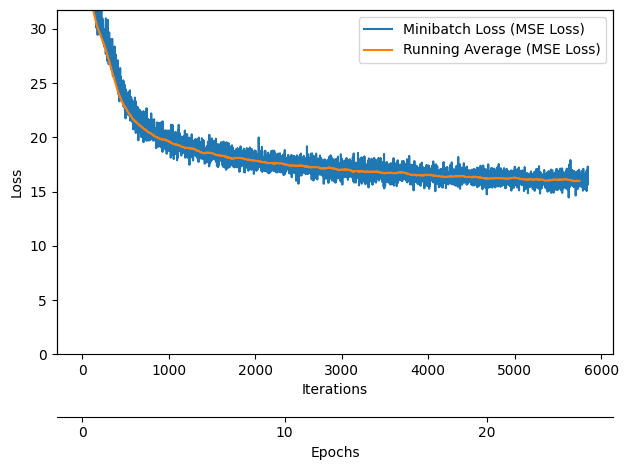

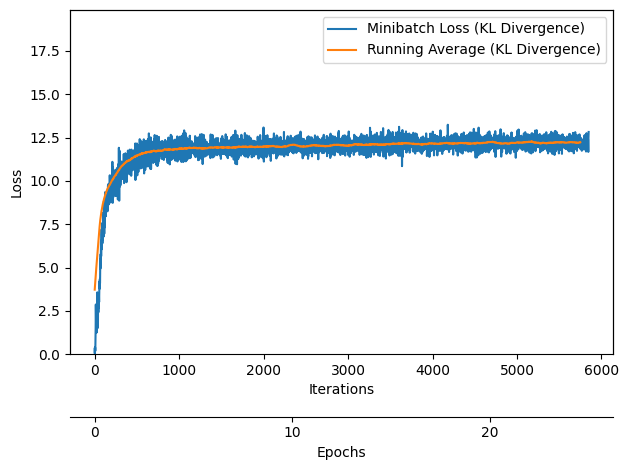

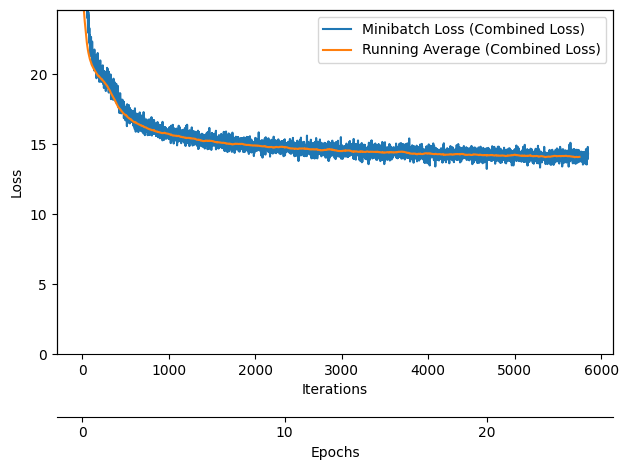

In [11]:
plot_training_loss(log_dict['mse_loss_per_batch'], config["epochs"], custom_label=" (MSE Loss)")
plot_training_loss(log_dict['kl_loss_per_batch'], config["epochs"], custom_label=" (KL Divergence)")
plot_training_loss(log_dict['combined_loss_per_batch'], config["epochs"], custom_label=" (Combined Loss)")
plt.show()

Reload model

In [ ]:
model = VAE().cuda()
model.load_state_dict(torch.load('.cache/models/vae.pt'))
model.eval()

### Visualization

#### Plot generated images

In [6]:
def plot_generated_images(data_loader, model, unnormalizer=None, figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (x, _) in enumerate(data_loader):
        x = x.cuda()
        color_channels = x.shape[1]
        image_height = x.shape[2]
        image_width = x.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                x_ = model(x)[:n_images]
            elif modeltype == 'VAE':
                z, z_mu, z_log_var, x_ = model(x)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        x = x[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [x, x_]):
            curr_img = img[i].detach().cpu()
            
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

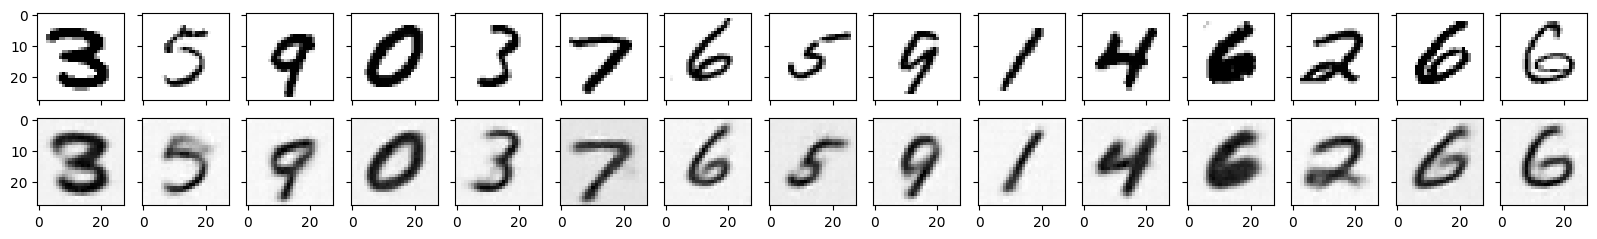

In [61]:
plot_generated_images(data_loader=train_loader, model=model, modeltype='VAE')   

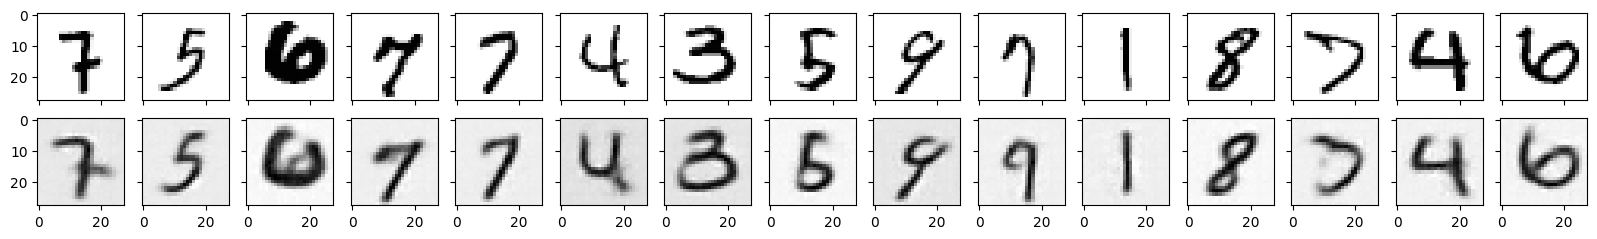

In [98]:
plot_generated_images(data_loader=train_loader, model=model, modeltype='VAE')   

#### Plot 2D latent space

In [26]:
embedding = []
label = []
model.eval()
with torch.inference_mode():
    for x, y in train_loader:
        z, z_mu, z_log_var, x_ = model(x.cuda())
        label.extend(y.detach().numpy())
        embedding.extend(z.detach().cpu().numpy())

In [27]:
embedding = np.array(embedding)
label = np.array(label)

In [29]:
reduced_embedding = umap.UMAP().fit_transform(embedding)
reduced_embedding.shape

(59904, 2)

In [ ]:
plt.figure(figsize=(15, 7))
scatter = plt.scatter(reduced_embedding[:, 0], reduced_embedding[:, 1], c=label, cmap='tab10', s=50, alpha=0.8)
plt.colorbar(scatter, ticks=range(10))
plt.title('PCA of z')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
def principal_component_analysis(x):
    x_mean = torch.mean(x, dim=0)
    x_centered = x - x_mean
    U, S, V = torch.svd(x_centered)
    components = torch.mm(x_centered, V[:, :2])
    return components

components = principal_component_analysis(z).detach().cpu().numpy()
y = y.detach().cpu().numpy()

plt.figure(figsize=(15, 7))
scatter = plt.scatter(components[:, 0], components[:, 1], c=y, cmap='tab10', s=50, alpha=0.8)
plt.colorbar(scatter, ticks=range(10))
plt.title('PCA of x')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [100]:
def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn):
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):

            x = x.cuda()
            y = y.cuda()
            
            z = encoding_fn(x)

            for i in range(num_classes):
                if i in y:
                    mask = y == i
                    d[i].append(z[mask].cpu().numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

In [ ]:
plot_latent_space_with_labels(
    num_classes=config["num_classes"],
    data_loader=train_loader,
    encoding_fn=model.encoding_fn
)

plt.legend()
plt.show()

### Plot generated images from random latent space

In [105]:
def plot_images_sampled_from_vae(model, latent_size, unnormalizer=None, num_images=10):

    with torch.no_grad():

        # random sample
        x = torch.randn(num_images, latent_size).cuda()
        x_ = model.decoder(x)
        color_channels = x_.shape[1]
        image_height = x_.shape[2]
        image_width = x_.shape[3]

        # visualization
        image_width = 28
        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        x_ = x_[:num_images]

        for ax, img in zip(axes, x_):
            curr_img = img.detach().cpu()
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary') 

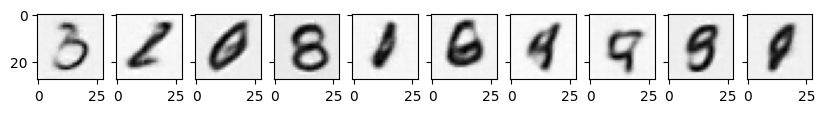

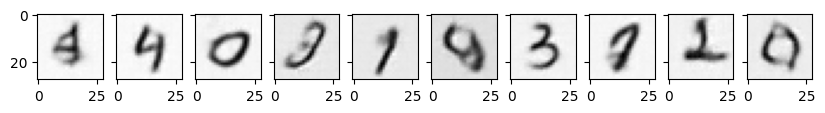

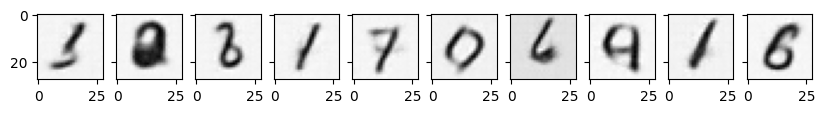

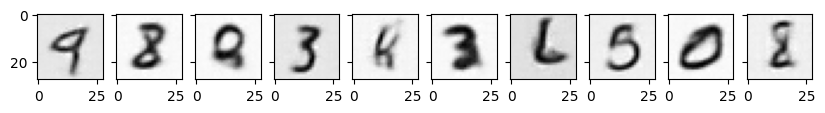

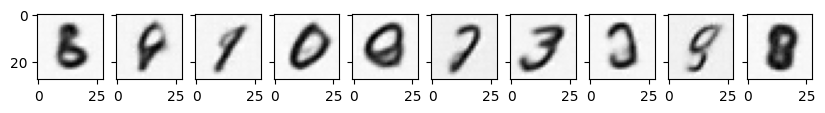

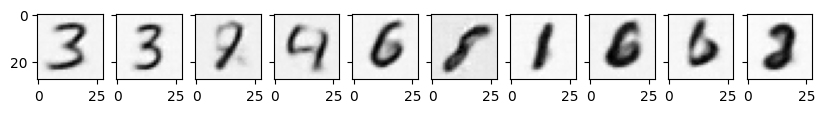

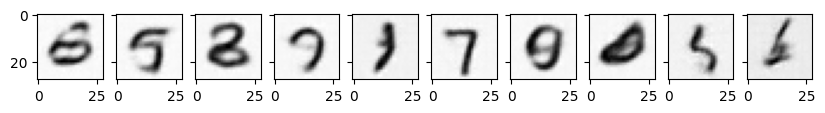

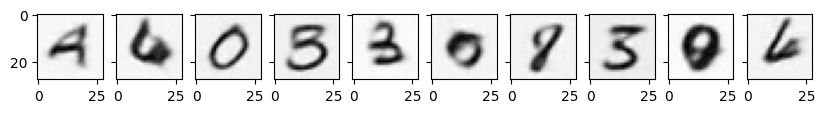

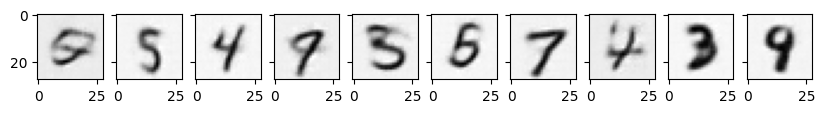

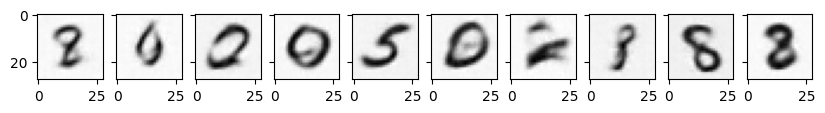

In [106]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, latent_size=200)
    plt.show()

## Face Dataset

In [34]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
from abc import abstractmethod

Tensor = TypeVar('torch.tensor')

In [ ]:
class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [ ]:
class VanillaVAE(BaseVAE):
    def __init__(self, in_channels: int, latent_dim: int, hidden_dims: List = None, **kwargs) -> None:
        super(VanillaVAE, self).__init__()
        self.latent_dim = latent_dim
        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)
        hidden_dims.reverse()
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1], kernel_size=3,
                                       stride = 2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], hidden_dims[-1], kernel_size=3,
                                stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels= 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std 

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self, num_samples:int, current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """
        return self.forward(x)[0]